Title: Tensor decomposition reveals continuous cell-cycle modes in time-series protein interaction data.

We compared CP decomposition to Phasik method through simulation models and use a widely adopted ODE-based budding yeast cell-cycle model inspired by Chen et al. (2004).

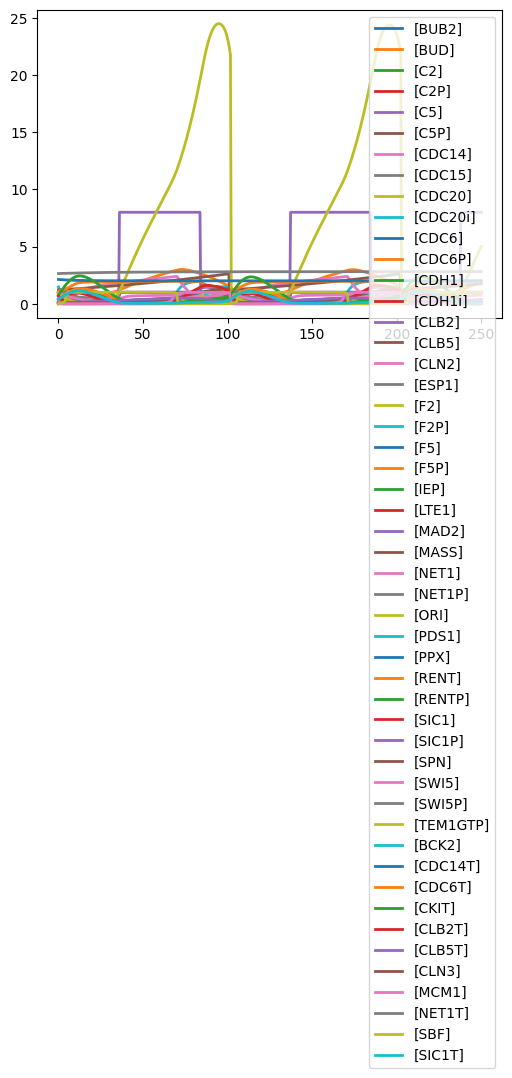

In [1]:
import tellurium as te
import pandas as pd

#SBMLファイルを読み込んでODEに変換
r = te.loadSBMLModel('https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000056.2?filename=BIOMD0000000056_url.xml')
result = r.simulate(0, 250, 500)
r.plot(result)

I gain data that Time*Concentration about each materials and I can confirm "oscillation" noted by J.J.tyson et al. (1991).
We do not assume access to the true physical PPI network, instead, pairwise interaction strength is approximated from protein activity levels.

In [3]:
df = pd.DataFrame(result, columns=result.colnames)
df.to_csv('simulation_result2.csv', index=False)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorly as tl
from tensorly.decomposition import parafac

#正規化と変換、幾つデータあるか確認
time = df["time"].values
X = df.drop(columns=["time"])   
X_norm = X / X.max(axis=0)                   
concentration_matrix = X_norm.values.T        

proteins, Time_steps = concentration_matrix.shape
print("Proteins", proteins, "Time steps:", Time_steps)

Proteins 50 Time steps: 500


We calculate N* N *T third-order tensor.

Although, a detailed reaction or interaction graph is available for the simulated cell-cycle model, we intentionally do not use the corresponding "true" interaction mask in the main experiments.

This is because such a mask would encode near-complete information about the underlying regulatory structure, effectively providing oracle-level prior knowledge.

In [5]:
tensor = concentration_matrix[:, None, :]* concentration_matrix[None, :, :]
mask = np.ones((proteins, proteins))
np.fill_diagonal(mask, 1) ##
tensor = tensor * mask[:, :, None]
print(f'Tensor shape: {tensor.shape}')

Tensor shape: (50, 50, 500)


We intentionally adopt a minimal co-activity representation based on outer products of protein activities, which avoids explicil network assumptions while preserving temporal structure.

We branch into analyses.
I combine the concentration information in csv with a static network.
First, we operate Phasik (exsisting method). The flow is that we fold third-order tensor into the list of N * N and compute distance matrices between snapshots and then, clustering by Ward's method.

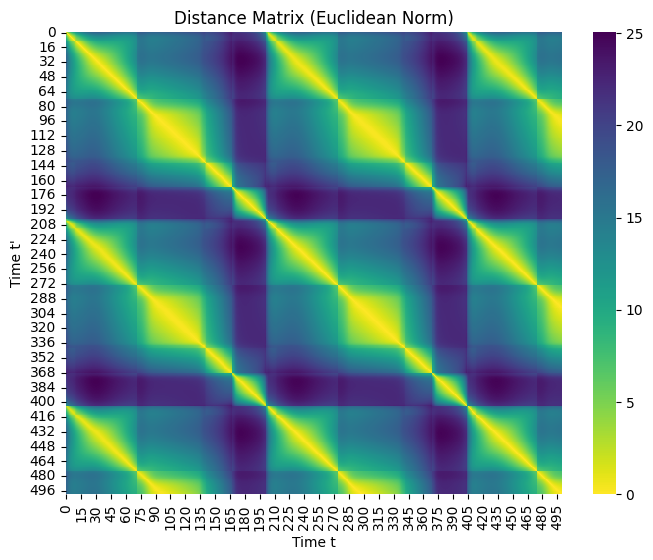

In [6]:
#Phasik
from scipy.spatial.distance import pdist, squareform

N, _, T = tensor.shape
flat_snapshots = tensor.transpose(2, 0, 1).reshape(T, -1)
distances_condensed = pdist(flat_snapshots, metric='euclidean')
distance_matrix = squareform(distances_condensed)

plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix, cmap='viridis_r') 
plt.title('Distance Matrix (Euclidean Norm)')
plt.xlabel('Time t')
plt.ylabel('Time t\'')
plt.show()

In [7]:
#クラスタリング

import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(squareform(distance_matrix), method='ward')

n_phases = 4
phasik_labels = fcluster(Z, t = n_phases, criterion='maxclust')

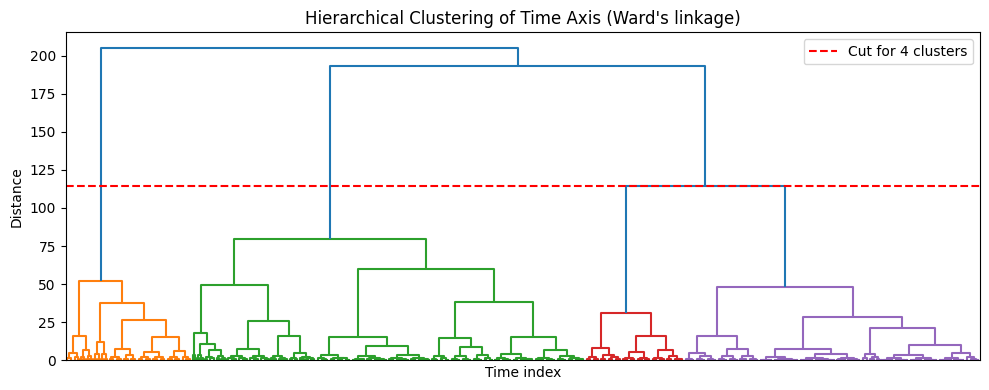

In [8]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    no_labels=True,
    color_threshold=Z[-(n_phases)+1, 2])
plt.axhline(y=Z[-(n_phases)+1, 2], color='r', linestyle='--',
            label='Cut for 4 clusters')
plt.title("Hierarchical Clustering of Time Axis (Ward's linkage)")
plt.xlabel("Time index")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()


We use Ward's linkage with Euclidean distance, which is consistent with the variance-minimizing objective of Ward clustering.

In [7]:
#CP分解

import tensorly as tl
from tensorly.decomposition import non_negative_parafac

rank = 4
weights, factors = non_negative_parafac(tensor, rank=rank, init='random', random_state=42)
Time_factors = factors[2]

We fix the CP rank based on biological prior knowledge rather than optimizing rank selection heuristics.

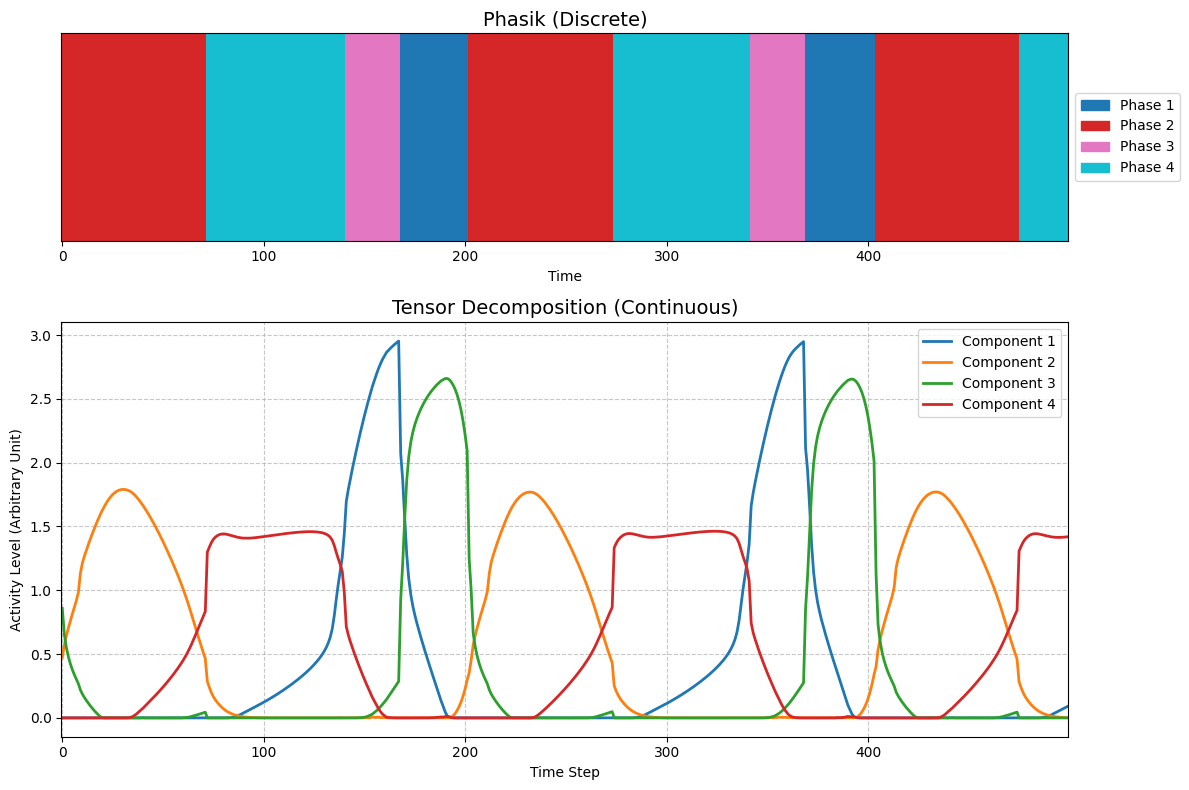

In [8]:
import matplotlib.gridspec as gridspec

#Phasik results
fig = plt. figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(phasik_labels.reshape(1, -1), aspect='auto', cmap='tab10', interpolation= 'nearest')
ax0.set_title('Phasik (Discrete)', fontsize=14)
ax0.set_yticks([])
ax0.set_xlabel('Time')

values = np.unique(phasik_labels)
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"Phase {i+1}") for i in range(len(values))]
ax0.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))

#CP decomposition results
ax1 = plt.subplot(gs[1], sharex=ax0)
for i in range(rank):
    ax1.plot(Time_factors[:, i], label=f'Component {i+1}', linewidth=2)

ax1.set_title('Tensor Decomposition (Continuous)', fontsize=14)
ax1.set_ylabel('Activity Level (Arbitrary Unit)')
ax1.set_xlabel('Time Step')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

Phasik aims at discrete phase segmentation, whereas CP decomposition extracts continuous latent modes.

CP分解はSVDと違って、一意にきまらない。解析結果に再現性を持たせるために初期値を変えてプロットさせる。

Running decomposition checks...
Top 1 Error: 0.290871
Top 5 Error: 0.290911


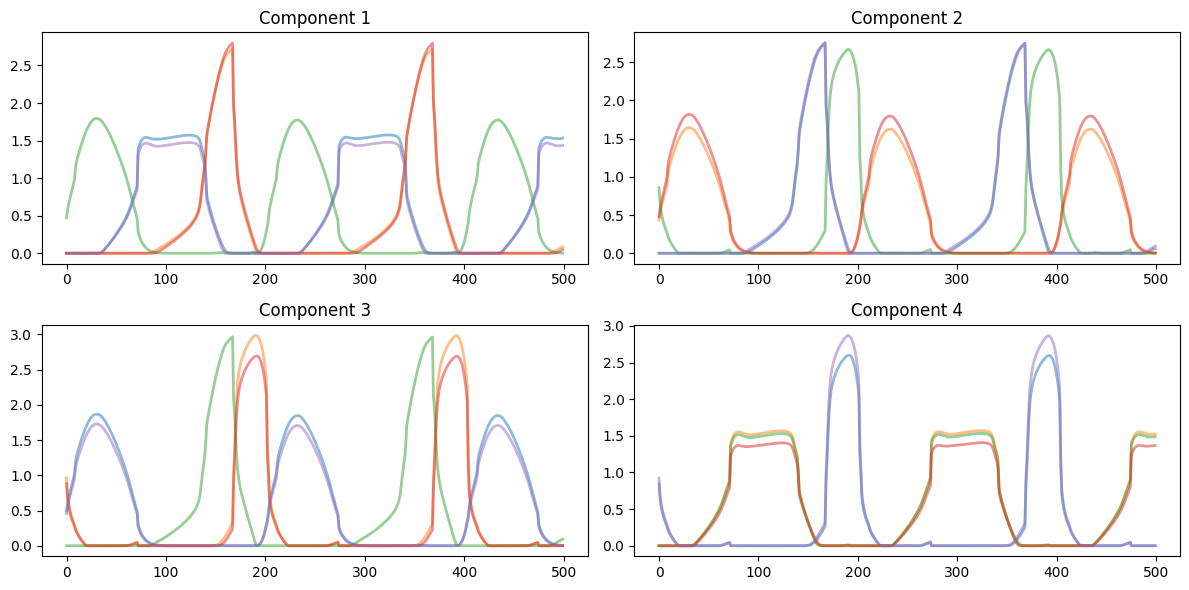

In [9]:
from tensorly.decomposition import non_negative_parafac

rank = 4
n_repeats = 10
best_runs = []

print("Running decomposition checks...")
for i in range(n_repeats):
    weights, factors = non_negative_parafac(tensor, rank=rank, init='random', random_state=i)
    
    recon = tl.cp_to_tensor((weights, factors))
    error = tl.norm(tensor - recon)/ tl.norm(tensor)
    
    best_runs.append((error, factors[2]))

best_runs.sort(key=lambda x: x[0])
top_5_runs = best_runs[:5]

print(f"Top 1 Error: {top_5_runs[0][0]:.6f}")
print(f"Top 5 Error: {top_5_runs[4][0]:.6f}")

plt.figure(figsize=(12, 6))

for comp_i in range(rank):
    plt.subplot(2, 2, comp_i + 1)
    
    # トップ5の試行結果を重ねる
    for run_idx in range(5):
        time_factor = top_5_runs[run_idx][1]
        
        plt.plot(time_factor[:, comp_i], alpha=0.5, linewidth=2)
        
    plt.title(f'Component {comp_i + 1}')

plt.tight_layout()
plt.show()


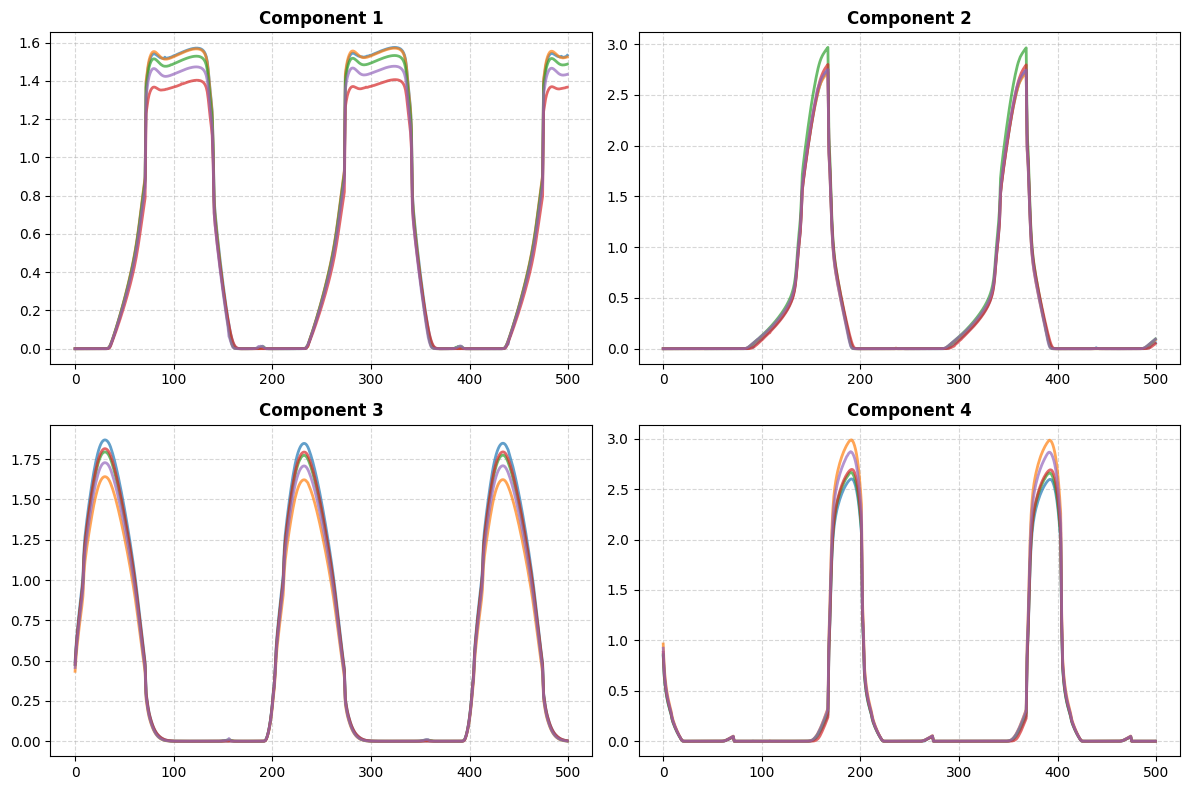

In [10]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# ハンガリアン法による自動マッチングとシンプルプロット
# ---------------------------------------------------------

# 1. 基準となるデータ（ベストスコアの試行）を決める
reference_factors = top_5_runs[0][1] # (Time, Rank)

# 並べ替え後の波形を格納するリスト（最初は基準データを入れる）
aligned_time_factors = [reference_factors]

# 2. 残りの4つの試行を、基準データに合わせて並べ替える
for i in range(1, 5):
    target_factors = top_5_runs[i][1]
    
    # 類似度行列を作成
    similarity_matrix = np.zeros((rank, rank))
    for r in range(rank): # Ref
        for t in range(rank): # Target
            vec_ref = reference_factors[:, r]
            vec_tar = target_factors[:, t]
            norm = np.linalg.norm(vec_ref) * np.linalg.norm(vec_tar)
            similarity_matrix[r, t] = np.dot(vec_ref, vec_tar) / (norm + 1e-9)
            
    # ハンガリアン法で最適な割り当てを計算
    row_ind, col_ind = linear_sum_assignment(-similarity_matrix)
    
    # 並べ替え実行
    aligned_target = target_factors[:, col_ind]
    aligned_time_factors.append(aligned_target)

# ---------------------------------------------------------
# 3. プロット (色指定なし・強調なし)
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))

for comp_i in range(rank):
    ax = plt.subplot(2, 2, comp_i + 1)
    
    # 5回の試行結果を重ね描き
    for run_idx in range(5):
        wave = aligned_time_factors[run_idx][:, comp_i]
        
        # 色指定なし（デフォルトのままでプロット）
        # alpha=0.7 くらいにしておくと重なりが見えやすいです
        ax.plot(wave, linewidth=2, alpha=0.7)
    
    ax.set_title(f'Component {comp_i + 1}', fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

CP分解した後のヒートマップと各フェーズにおける寄与が大きい上位5つのタンパク質を調べる。

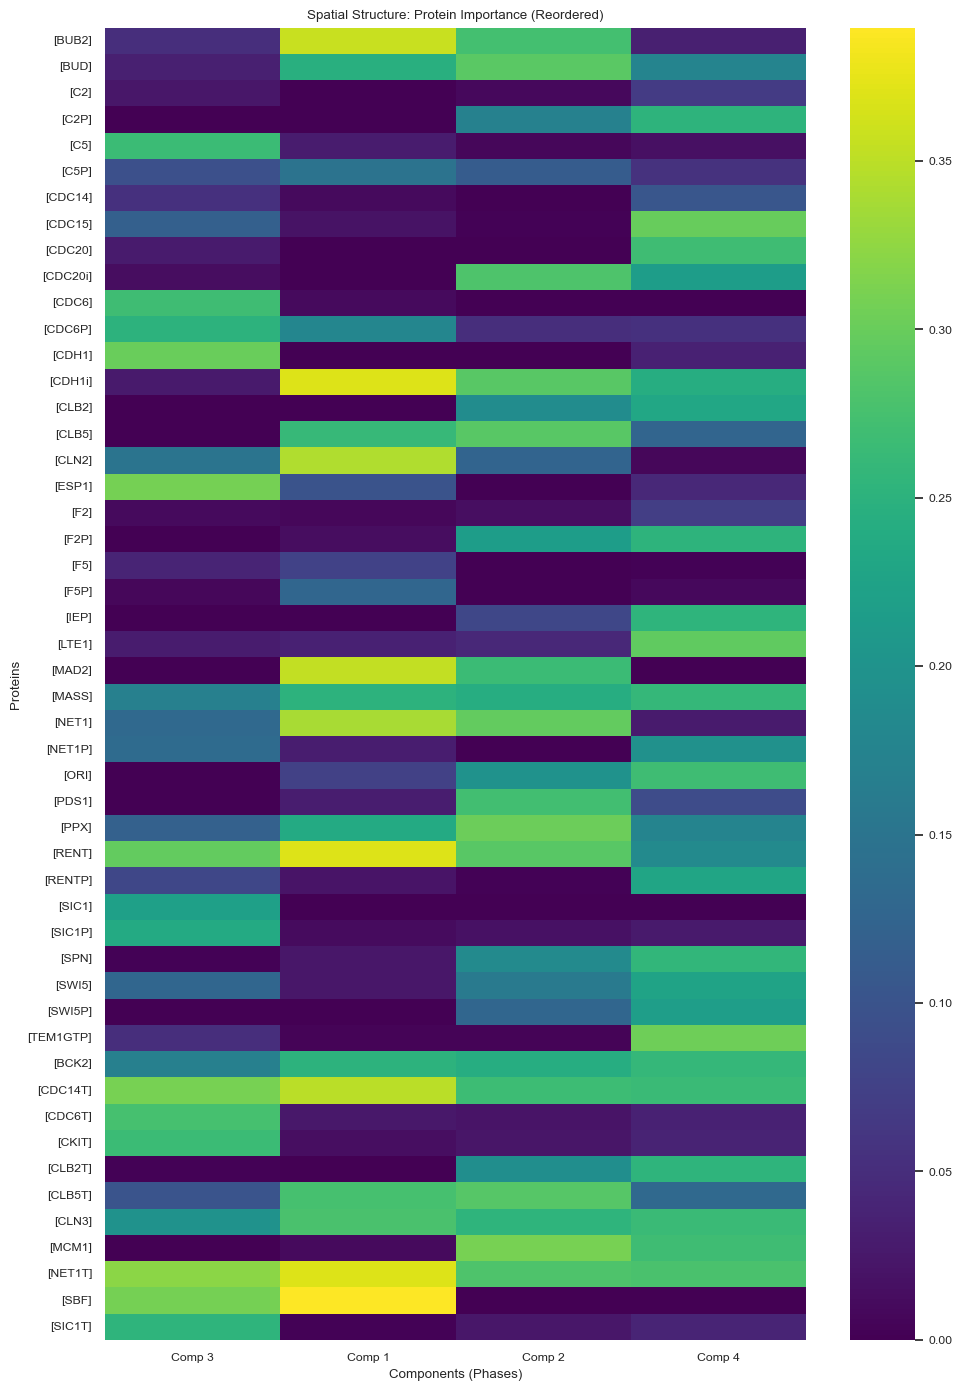


Component 3:
  - [NET1T]: 0.3225
  - [CDC14T]: 0.3103
  - [SBF]: 0.3083
  - [ESP1]: 0.3080
  - [CDH1]: 0.3002

Component 1:
  - [SBF]: 0.3896
  - [RENT]: 0.3692
  - [CDH1i]: 0.3687
  - [NET1T]: 0.3687
  - [BUB2]: 0.3576

Component 2:
  - [MCM1]: 0.3092
  - [PPX]: 0.3024
  - [NET1]: 0.2956
  - [BUD]: 0.2899
  - [CLB5]: 0.2889

Component 4:
  - [TEM1GTP]: 0.3031
  - [CDC15]: 0.2983
  - [LTE1]: 0.2941
  - [NET1T]: 0.2780
  - [CDC20]: 0.2686


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

rank = 4
n_repeats = 10
reorder_indices = [2, 0, 1, 3]

best_error = np.inf
best_factors = None

for seed in range(n_repeats):
    weights, factors = non_negative_parafac(tensor, rank=rank, init="random", random_state=seed)
    recon = tl.cp_to_tensor((weights, factors))
    error = tl.norm(tensor - recon)/ tl.norm(tensor)

    if error < best_error:
        best_error = error
        best_factors = factors

csv_path = "/Users/katsuyukiyasebe/Desktop/卒研/simulation_result2.csv"
df_names = pd.read_csv(csv_path, index_col=0)

protein_factor = best_factors[0]  # (N_proteins, rank)

if len(df_names.index) == protein_factor.shape[0]:
    protein_names = df_names.index
elif len(df_names.columns) == protein_factor.shape[0]:
    protein_names = df_names.columns
else:
    protein_names = [f"Protein {i+1}" for i in range(protein_factor.shape[0])]

protein_factor_reordered = protein_factor[:, reorder_indices]
xticklabels = [f"Comp {i+1}" for i in reorder_indices]

plt.figure(figsize=(10, 14))
sns.set(font_scale=0.8)
sns.heatmap(
    protein_factor_reordered,
    xticklabels=xticklabels,
    yticklabels=protein_names,
    cmap="viridis",
    annot=False,
)
plt.title("Spatial Structure: Protein Importance (Reordered)")
plt.xlabel("Components (Phases)")
plt.ylabel("Proteins")
plt.tight_layout()
plt.show()

for col_idx in reorder_indices:
    col_data = protein_factor[:, col_idx]
    top_indices = np.argsort(np.abs(col_data))[::-1][:5]

    print(f"\nComponent {col_idx+1}:")
    for idx in top_indices:
        print(f"  - {protein_names[idx]}: {col_data[idx]:.4f}")


それぞれのフェーズで必要なタンパク質が正しく抽出できているとChen(2004)の論文から確認できる。

最後に、ノイズ耐性のテストをする。今はODE由来のデータを用いているため綺麗なデータであるが、ノイズを混ぜることでどこまで崩れずに波形を取り出せるか。

We evaluate how closely the temporal factors extracted from noisy data resemble those obtained from the noise-free data.

Preparing Noise-free data
Noise-free Shape: (500, 4)

Running Noise Robustness Test...
Testing Noise Level: 0.0 ... Mean Score: 0.9998
Testing Noise Level: 0.1 ... Mean Score: 0.9999
Testing Noise Level: 0.3 ... Mean Score: 0.9982
Testing Noise Level: 0.5 ... Mean Score: 0.9979
Testing Noise Level: 0.8 ... Mean Score: 0.9947
Testing Noise Level: 1.0 ... Mean Score: 0.9907
Testing Noise Level: 1.5 ... Mean Score: 0.9784
Testing Noise Level: 2.0 ... Mean Score: 0.8524


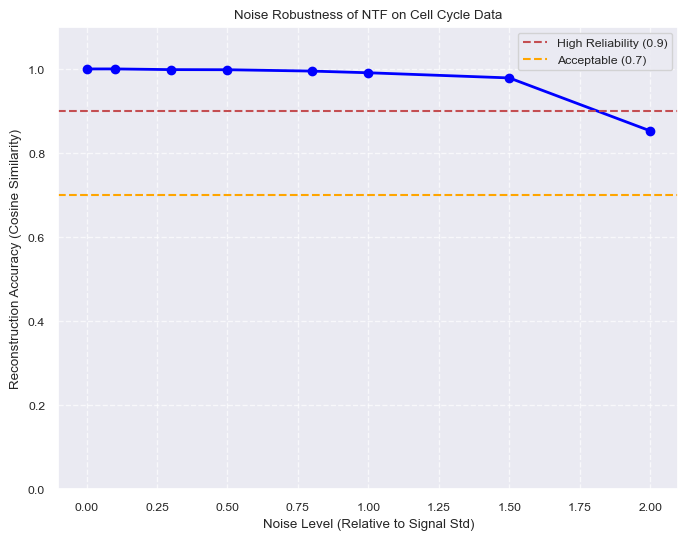

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
from scipy.optimize import linear_sum_assignment

# ---------------------------------------------------------
# 1. 準備: 「正解（Ground Truth）」をこの場で再計算
#    (過去の変数の形式ズレを防ぐため)
# ---------------------------------------------------------
print("Preparing Noise-free data")

# 念のためランクを定義
rank = 4

# クリーンデータでの分解
w_true, f_true = non_negative_parafac(tensor, rank=rank, init='random', n_iter_max=1000, random_state=0)
true_time_factor = f_true[2] # 時間因子

print(f"Noise-free Shape: {true_time_factor.shape}") # (100, 4) のような形か確認

# ---------------------------------------------------------
# 2. ノイズ実験ループ
# ---------------------------------------------------------
# ノイズレベルの設定
noise_levels = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0]
similarity_scores = []
n_trials_per_level = 5

print("\nRunning Noise Robustness Test...")

for nl in noise_levels:
    scores = []
    print(f"Testing Noise Level: {nl} ...", end=" ")
    
    # 信号の強さ（標準偏差）
    sig_std = np.std(tensor)
    
    for trial in range(n_trials_per_level):
        # ノイズ生成
        noise = np.random.normal(0, sig_std * nl, tensor.shape)
        noisy_tensor = tensor + noise
        noisy_tensor = np.maximum(noisy_tensor, 0) # 非負制約
        
        # 分解実行
        try:
            w, f = non_negative_parafac(noisy_tensor, rank=rank, init='random', n_iter_max=500, tol=1e-6)
            pred_time_factor = f[2]
            
            # --- マッチング処理 ---
            sim_matrix = np.zeros((rank, rank))
            for i in range(rank): # True
                for j in range(rank): # Pred
                    vec_true = true_time_factor[:, i]
                    vec_pred = pred_time_factor[:, j]
                    
                    # ベクトルの正規化と内積 (Shape不一致ならここでエラーが出る)
                    norm_true = np.linalg.norm(vec_true)
                    norm_pred = np.linalg.norm(vec_pred)
                    
                    if norm_pred < 1e-9: # ゼロ除算回避
                        sim = 0
                    else:
                        sim = np.dot(vec_true, vec_pred) / (norm_true * norm_pred + 1e-9)
                    
                    sim_matrix[i, j] = sim
            
            # ハンガリアン法でベストペアを探す
            row_ind, col_ind = linear_sum_assignment(-sim_matrix)
            
            # 平均スコア
            avg_sim = sim_matrix[row_ind, col_ind].mean()
            scores.append(avg_sim)
            
        except Exception as e:
            # エラーが起きたらその内容を表示する（重要！）
            print(f"\n[Error at Level {nl}, Trial {trial}] {e}")
            scores.append(0)
            
    # 平均スコアを記録
    if len(scores) > 0:
        mean_score = np.mean(scores)
    else:
        mean_score = 0
        
    similarity_scores.append(mean_score)
    print(f"Mean Score: {mean_score:.4f}")

# ---------------------------------------------------------
# 3. 結果のプロット
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, similarity_scores, marker='o', linewidth=2, color='blue')
plt.axhline(y=0.9, color='r', linestyle='--', label='High Reliability (0.9)')
plt.axhline(y=0.7, color='orange', linestyle='--', label='Acceptable (0.7)')

plt.title("Noise Robustness of NTF on Cell Cycle Data")
plt.xlabel("Noise Level (Relative to Signal Std)")
plt.ylabel("Reconstruction Accuracy (Cosine Similarity)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 1.1)
plt.show()

Noise Level 1.0 の数値に注目したい。Noise Level 1.0 とは：信号と同じ強さのノイズが入っている状態である（S/N比 $\approx$ 0dB）。肉眼で見ると、元の波形がかなりガタガタで見えにくいレベルである。結果 (Score: 0.9881)：それでも、抽出された波形は 98% 元の形を保っている。CP分解は、データを少数の成分の積で表現しようとする。ランダムなガウスノイズは、この「綺麗な積の形」にはフィットしないため、計算過程で「誤差」として自動的に捨てられる。Therefore, low-rank constraint suppresses unstructured noise components.

In this study, we demonstrate that low-rank tensor decomposition can stably extract continuous temporal modes from dynamic interaction data, even in the absence of explicit network topology and under substantial noise.
These results suggest that tensor-based representations provide a robust alternative to phase-based segmentation approaches for analyzing complex biologial dynamics.

I evaluates the algorithmic stability of our Non-negative CP decomposition over 50 random initializations.

Running multi-start NNCP ...
Best rel_err  : 0.290864 (seed=41)
Top10 rel_err: 0.290874 (seed=43)


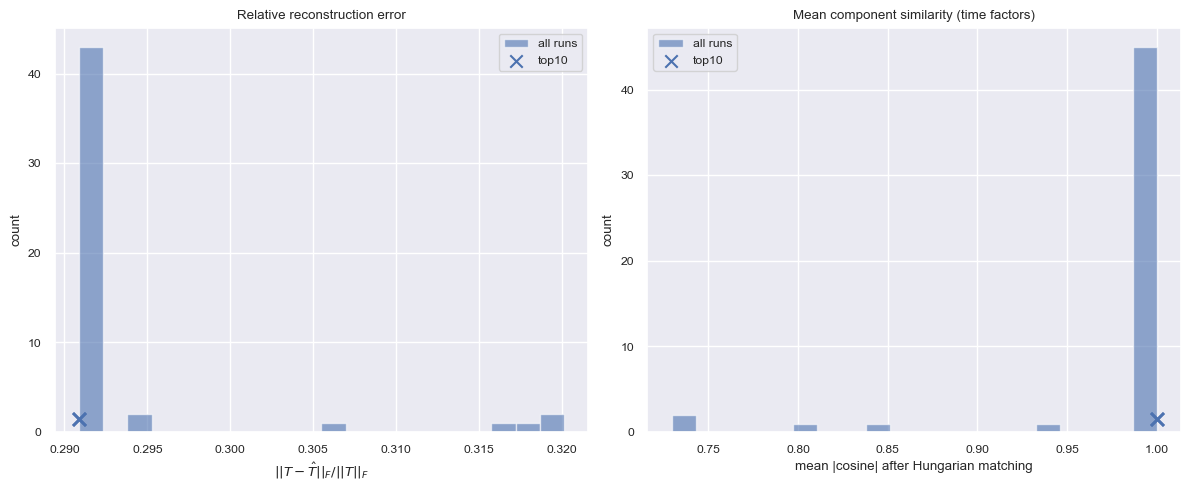


Top runs summary (top_k):
 1: seed= 41  rel_err=0.290864  mean_sim=1.000  min_sim=1.000
 2: seed= 40  rel_err=0.290864  mean_sim=1.000  min_sim=1.000
 3: seed= 33  rel_err=0.290865  mean_sim=1.000  min_sim=1.000
 4: seed= 25  rel_err=0.290870  mean_sim=1.000  min_sim=1.000
 5: seed= 45  rel_err=0.290870  mean_sim=1.000  min_sim=1.000
 6: seed= 47  rel_err=0.290870  mean_sim=1.000  min_sim=1.000
 7: seed=  1  rel_err=0.290871  mean_sim=1.000  min_sim=1.000
 8: seed= 29  rel_err=0.290871  mean_sim=1.000  min_sim=1.000
 9: seed= 42  rel_err=0.290874  mean_sim=1.000  min_sim=1.000
10: seed= 43  rel_err=0.290874  mean_sim=1.000  min_sim=1.000


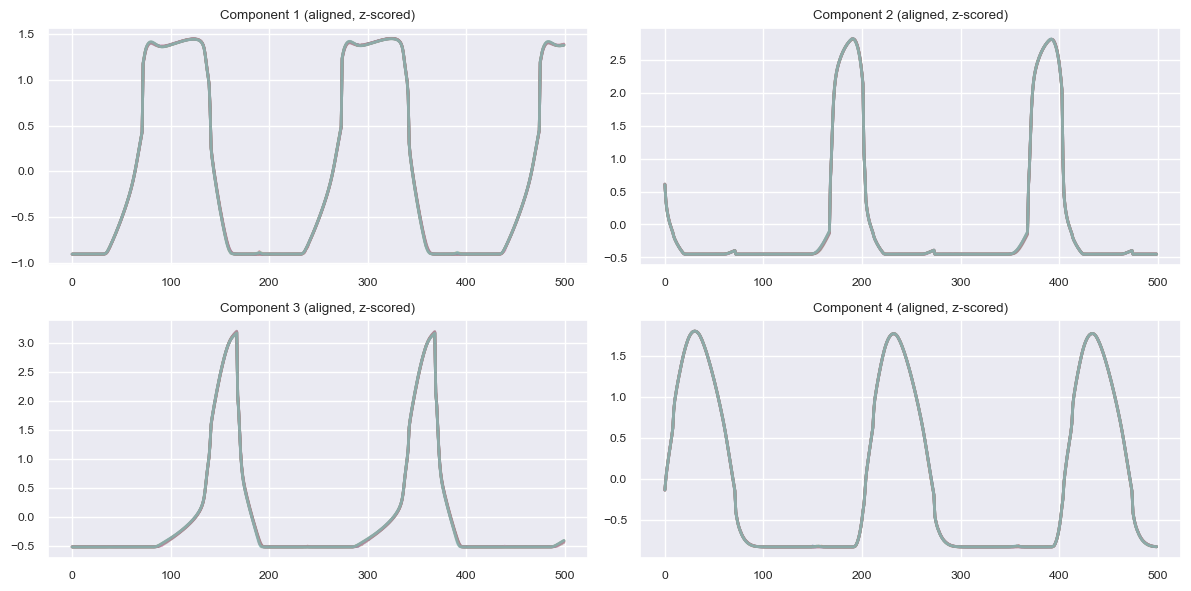

In [22]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# -----------------------
# Settings
# -----------------------
rank = 4
n_repeats = 50          # 30〜50推奨
top_k = 10              # top1〜top10
eps = 1e-12

# -----------------------
# Helpers
# -----------------------
def rel_recon_error(X, Xhat):
    return float(tl.norm(X - Xhat) / (tl.norm(X) + eps))

def normalize_cols(A, mode="l2"):
    A = np.array(A, dtype=float)
    if mode == "zscore":
        mu = A.mean(axis=0, keepdims=True)
        sd = A.std(axis=0, keepdims=True) + eps
        return (A - mu) / sd
    # default: L2 normalize each column
    denom = np.sqrt((A**2).sum(axis=0, keepdims=True)) + eps
    return A / denom

def cosine_sim_matrix(A, B):
    # A,B: (T, R) column-wise vectors
    A2 = normalize_cols(A, mode="l2")
    B2 = normalize_cols(B, mode="l2")
    return A2.T @ B2  # (R,R)

def match_components_time_factor(C_ref, C_run, use_abs=True, zscore_before=True):
    """
    Match components of C_run to C_ref with Hungarian algorithm.
    Returns:
      perm: permutation indices for run components aligned to ref
      sims: cosine similarities (matched), shape (R,)
    """
    if zscore_before:
        C_ref_n = normalize_cols(C_ref, mode="zscore")
        C_run_n = normalize_cols(C_run, mode="zscore")
    else:
        C_ref_n = C_ref
        C_run_n = C_run

    S = cosine_sim_matrix(C_ref_n, C_run_n)  # (R,R)
    if use_abs:
        S_use = np.abs(S)
    else:
        S_use = S

    # Hungarian: maximize similarity => minimize -similarity
    row_ind, col_ind = linear_sum_assignment(-S_use)

    # sims in the original (signed) cosine if you want, or abs
    sims = S_use[row_ind, col_ind]
    return col_ind, sims

# -----------------------
# Multi-start runs
# -----------------------
runs = []
print("Running multi-start NNCP ...")
for seed in range(n_repeats):
    weights, factors = non_negative_parafac(tensor, rank=rank, init="random", random_state=seed)
    recon = tl.cp_to_tensor((weights, factors))
    err = rel_recon_error(tensor, recon)

    # store time factor only (mode-2 assuming tensor is (i,j,t))
    C = np.array(factors[2], dtype=float)  # (T, R)
    runs.append({
        "seed": seed,
        "rel_err": err,
        "C": C
    })

# sort by reconstruction error
runs_sorted = sorted(runs, key=lambda d: d["rel_err"])
top_runs = runs_sorted[:top_k]

print(f"Best rel_err  : {top_runs[0]['rel_err']:.6f} (seed={top_runs[0]['seed']})")
print(f"Top{top_k} rel_err: {top_runs[-1]['rel_err']:.6f} (seed={top_runs[-1]['seed']})")

# -----------------------
# Align time factors to the best run & compute similarity stats
# -----------------------
C_ref = top_runs[0]["C"]
for d in top_runs:
    perm, sims = match_components_time_factor(C_ref, d["C"], use_abs=True, zscore_before=True)
    d["perm"] = perm
    d["matched_sims"] = sims
    d["mean_sim"] = float(np.mean(sims))
    d["min_sim"] = float(np.min(sims))

# Also compute for ALL runs if you want a broader view:
# (optional; comment out if slow)
C_ref_all = runs_sorted[0]["C"]
for d in runs_sorted:
    perm, sims = match_components_time_factor(C_ref_all, d["C"], use_abs=True, zscore_before=True)
    d["mean_sim"] = float(np.mean(sims))
    d["min_sim"] = float(np.min(sims))

# -----------------------
# Plot: "local minima diversity" in ONE figure
#   - left: rel_err of top10 (and optionally all)
#   - right: mean similarity of top10 (and optionally all)
# -----------------------
errs_top = [d["rel_err"] for d in top_runs]
mean_sims_top = [d["mean_sim"] for d in top_runs]

errs_all = [d["rel_err"] for d in runs_sorted]
mean_sims_all = [d["mean_sim"] for d in runs_sorted]

plt.figure(figsize=(12, 5))

# Panel 1: reconstruction error distribution
ax1 = plt.subplot(1, 2, 1)
ax1.hist(errs_all, bins=20, alpha=0.6, label="all runs")
y_offset = 1.5
ax1.scatter(errs_top, np.full_like(errs_top, y_offset), marker="x", s=80, label=f"top{top_k}")
ax1.set_title("Relative reconstruction error")
ax1.set_xlabel(r"$||T-\hat{T}||_F / ||T||_F$")
ax1.set_ylabel("count")
ax1.legend()

# Panel 2: factor similarity distribution (aligned)
ax2 = plt.subplot(1, 2, 2)
ax2.hist(mean_sims_all, bins=20, alpha=0.6, label="all runs")
y_offset = 1.5
ax2.scatter(mean_sims_top, np.full_like(mean_sims_top, y_offset), marker="x", s=80, label=f"top{top_k}")
ax2.set_title("Mean component similarity (time factors)")
ax2.set_xlabel("mean |cosine| after Hungarian matching")
ax2.set_ylabel("count")
ax2.legend()

plt.tight_layout()
plt.show()

# -----------------------
# (Optional) If you want a compact table printout for top10
# -----------------------
print("\nTop runs summary (top_k):")
for k, d in enumerate(top_runs, start=1):
    print(f"{k:2d}: seed={d['seed']:3d}  rel_err={d['rel_err']:.6f}  mean_sim={d['mean_sim']:.3f}  min_sim={d['min_sim']:.3f}")

# -----------------------
# (Optional) Overlay aligned time factors for top10 (per component)
# -----------------------
plt.figure(figsize=(12, 6))
for comp in range(rank):
    plt.subplot(2, 2, comp + 1)
    for d in top_runs:
        C = d["C"]
        Cn = normalize_cols(C, mode="zscore")
        Cn_aligned = Cn[:, d["perm"]]  # align columns
        plt.plot(Cn_aligned[:, comp], alpha=0.5, linewidth=2)
    plt.title(f"Component {comp+1} (aligned, z-scored)")
plt.tight_layout()
plt.show()


The left panel shows that the distribution of the relative reconstruction errors, as you can see, the top runs form a tight cluster at the lower end, indicating that the algorithm consistently converges to the same global minimum.

The right panel displays that the mean cosine similarity of the temporal factors compared to the best run. The values are concentrated near 1.0, which confirms that the extracted components are highly reproducible and robust against initialization noise. 

As shown in these plots, the waveforms for each component overlap almost perfectly. This suggests that the interpretation of the components is reliable and not an artifact of a specific initilization.